GAN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


Using: cuda


In [2]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # GAN works best with [-1,1]
])

train_dataset = datasets.MNIST(root="data", train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.95MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.4MB/s]


In [3]:
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.zeros_(m.bias)

class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 256, 7, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        self.apply(init_weights)

    def forward(self, z):
        return self.gen(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 1, 7, 1, 0),
            nn.Sigmoid()
        )
        self.apply(init_weights)

    def forward(self, x):
        return self.disc(x).view(-1, 1)

In [4]:
def show_generated(epoch):
    with torch.no_grad():
        imgs = G(fixed_z).cpu()
        generated_images_history.append(imgs.clone())

In [13]:
z_dim = 64
G = Generator(z_dim).to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
lr = 0.0002

G_opt = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_opt = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

fixed_z = torch.randn(64, z_dim, 1, 1, device=device)
generated_images_history = []

In [14]:

epochs = 10
for epoch in range(1, epochs+1):
    G_losses, D_losses = [], []
    for real, _ in train_loader:
        real = real.to(device)
        bs = real.size(0)

        # Train Discriminator
        D_opt.zero_grad()

        real_labels = torch.ones(bs, 1, device=device)
        fake_labels = torch.zeros(bs, 1, device=device)

        real_pred = D(real)
        D_real_loss = criterion(real_pred, real_labels)

        z = torch.randn(bs, z_dim, 1, 1, device=device)
        fake = G(z)
        fake_pred = D(fake.detach())
        D_fake_loss = criterion(fake_pred, fake_labels)

        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_opt.step()

        # Train Generator
        G_opt.zero_grad()
        fake_pred = D(fake)
        G_loss = criterion(fake_pred, real_labels)
        G_loss.backward()
        G_opt.step()

        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

    print(f"[{epoch}/{epochs}]  D_loss={sum(D_losses)/len(D_losses):.4f}  G_loss={sum(G_losses)/len(G_losses):.4f}")
    show_generated(epoch)

[1/10]  D_loss=0.8615  G_loss=1.4569
[2/10]  D_loss=0.6383  G_loss=1.7791
[3/10]  D_loss=0.5411  G_loss=2.0299
[4/10]  D_loss=0.5108  G_loss=2.1814
[5/10]  D_loss=0.5214  G_loss=2.2486
[6/10]  D_loss=0.5466  G_loss=2.2487
[7/10]  D_loss=0.5457  G_loss=2.1858
[8/10]  D_loss=0.5170  G_loss=2.3764
[9/10]  D_loss=0.5203  G_loss=2.2292
[10/10]  D_loss=0.4767  G_loss=2.4004


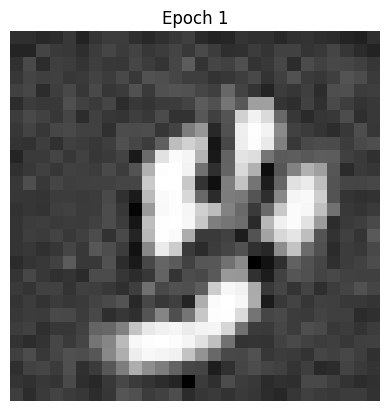

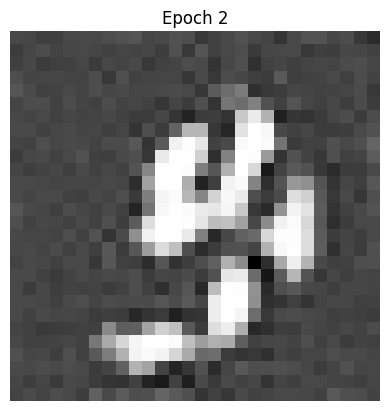

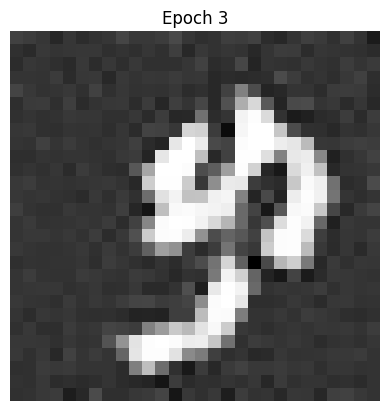

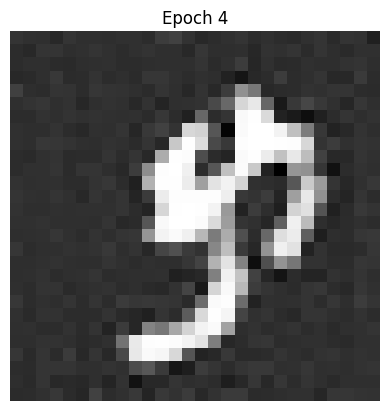

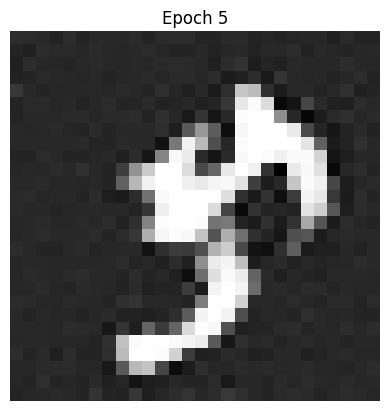

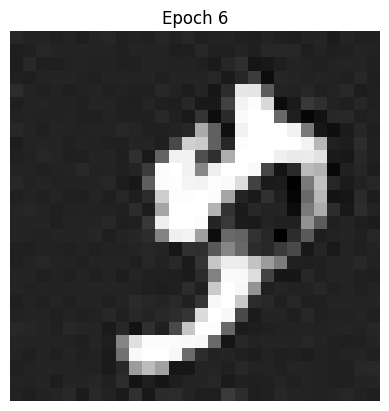

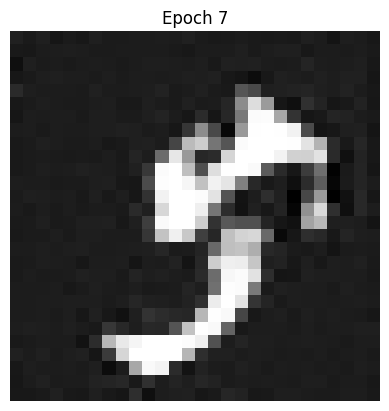

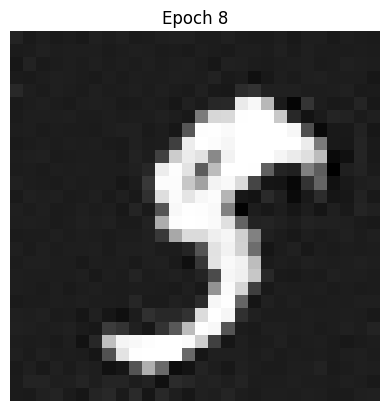

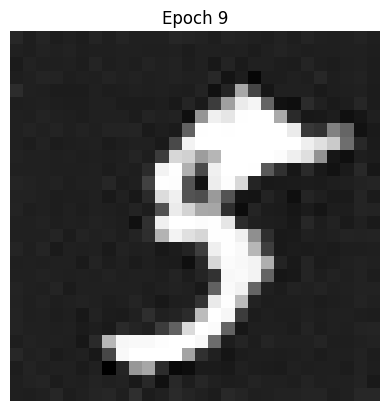

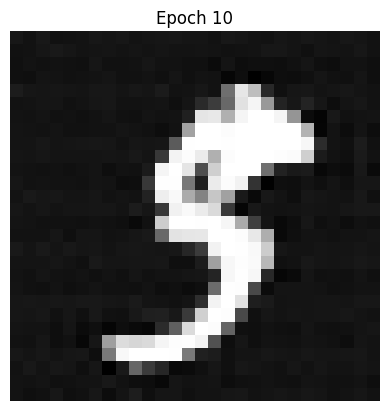

In [15]:
for i in range(len(generated_images_history)):
    img=generated_images_history[i]
    img = img[0].squeeze().numpy()
    plt.imshow(img, cmap="gray")
    plt.title(f"Epoch {i+1}")
    plt.axis("off")
    plt.show()


Autoencoder

In [8]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST("data", True, transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [9]:
def add_noise(x, noise_level=0.1):
    noise = torch.randn_like(x) * noise_level
    return torch.clamp(x + noise, 0., 1.)

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1),  # 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),

            nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, 2, 1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [11]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/10, Loss=0.0345
Epoch 2/10, Loss=0.0076
Epoch 3/10, Loss=0.0054
Epoch 4/10, Loss=0.0045
Epoch 5/10, Loss=0.0041
Epoch 6/10, Loss=0.0038
Epoch 7/10, Loss=0.0036
Epoch 8/10, Loss=0.0035
Epoch 9/10, Loss=0.0033
Epoch 10/10, Loss=0.0032


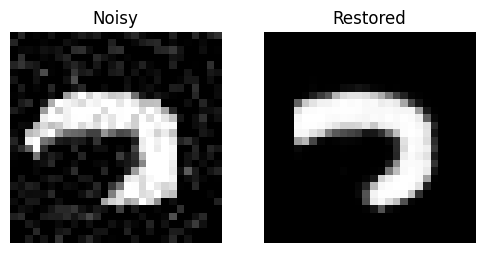

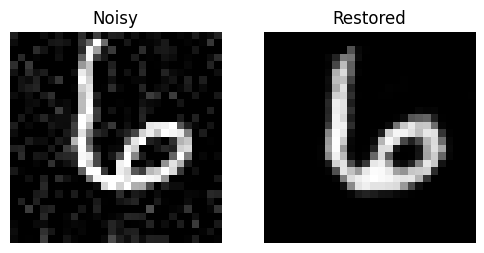

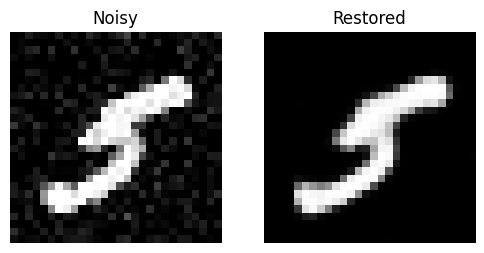

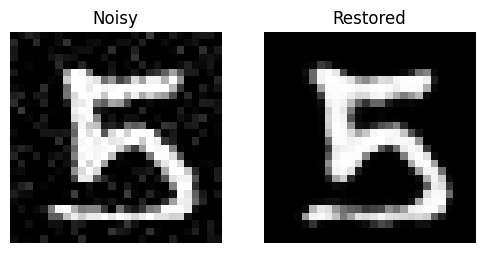

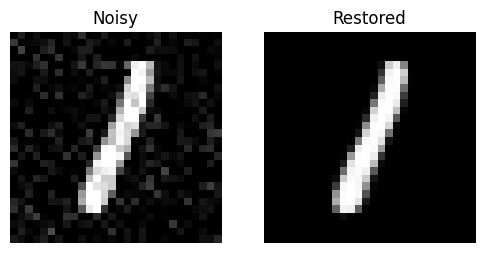

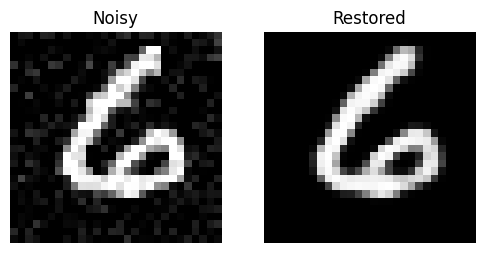

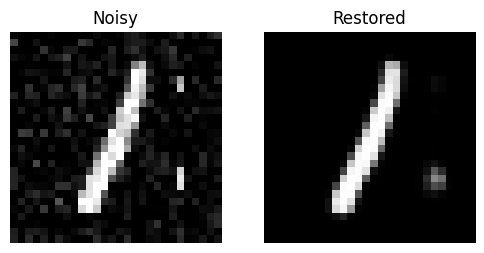

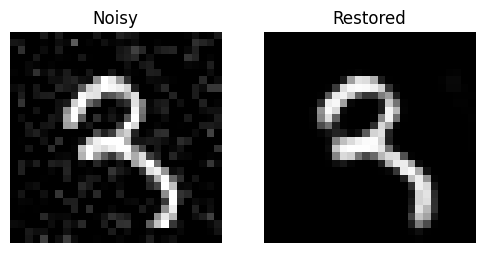

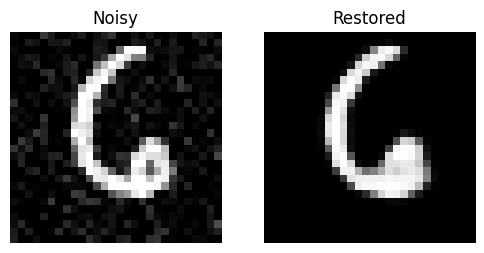

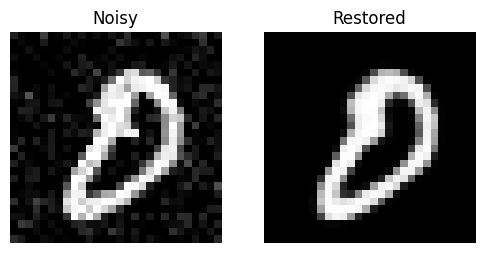

In [12]:
sample_images, restored_images=[], []
epochs = 10
for epoch in range(1, epochs+1):
    losses = []
    for x, _ in train_loader:
        x = x.to(device)
        noisy = add_noise(x)

        optimizer.zero_grad()
        pred = model(noisy)
        loss = criterion(pred, x)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch {epoch}/{epochs}, Loss={sum(losses)/len(losses):.4f}")

    with torch.no_grad():
      sample_images.append(noisy[0].cpu())
      restored_images.append(pred[0].cpu())

def show_restored(epoch):
    n = sample_images[epoch].squeeze().numpy()
    r = restored_images[epoch].squeeze().numpy()

    if n.ndim == 3 and n.shape[0] == 3:
        n, r = n.transpose(1,2,0), r.transpose(1,2,0)

    plt.figure(figsize=(6,3))
    plt.subplot(121); plt.imshow(n, cmap='gray'); plt.title('Noisy'); plt.axis('off')
    plt.subplot(122); plt.imshow(r, cmap='gray'); plt.title('Restored'); plt.axis('off')
    plt.show()

for epoch in range(epochs):
     show_restored(epoch)